In [1]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister, Aer, execute, assemble
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.circuit.library import MCMT, RYGate, RXGate, PhaseGate
import numpy as np
np.set_printoptions(threshold=np.inf)
import math
from typing import Union
import pickle
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_provider.accounts import AccountNotFoundError
print('qiskit ver.', qiskit.__version__)
print('numpy ver.', np.__version__)

qiskit ver. 0.45.1
numpy ver. 1.23.5


In [2]:
## Settings
d = 1 # of dimensions
M = 2 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 1 # of particles in the initial state
N_abs = 2 # of modes for momenta

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.

In [3]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    # particle registers
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))

    # ancilla registers
    ancilla_register_h0 = QuantumRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
    ancilla_register_symm = QuantumRegister(s + 1, name = f'aux_Bose') # aux registers for Bose symmetrization

    # classical registers
    classical_register_symm = ClassicalRegister(1, name = 'cla_Bose')
    classical_register_measurement = ClassicalRegister(N * M, name = 'particle measure')

    # merge into circuit
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement)
    particle_1D_list = [element for sublist in particle_registers for element in sublist]
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement, particle_1D_list

# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
# circuit.draw('mpl')

In [4]:
## exponential wave packet で局在化
def wavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        sigma = 1
        theta = math.atan(math.exp(- 2 ** (iqubit - 1) / sigma))
        wave_circ.ry(2 * theta, particle_reg[iqubit])
    wave_gate = wave_circ.to_gate()
    return wave_gate

## exponential wave packet で局在化
def preWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        eps = 0.15 # pがガウシアンになるように調整する必要あり
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
        wave_circ.ry(2 * theta_lin, particle_reg[iqubit])
    gauss_gate = wave_circ.to_gate()
    return gauss_gate

In [5]:
# function of Quantum Fourier Transformation
def qFT(num):
    qft_circuit = QuantumCircuit(num)
    for iqubit in range(num - 1, -1, -1):
        qft_circuit.h(iqubit)
        for ictrl in range(iqubit - 1, -1, -1):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit - 1 + num)
            phi = power * dphi
            qft_circuit.cp(phi, ictrl, iqubit)
    for iswap in range(num // 2):
        qft_circuit.swap(iswap, num-1-iswap)
    qft_circuit.to_gate()
    return qft_circuit

# function of inverse Quantum Fourier Transformation
def invQFT(num):
    inv_qft_circuit = QuantumCircuit(num)
    for iswap in range(num // 2):
        inv_qft_circuit.swap(iswap, num-1-iswap)
    for iqubit in range(num):
        for ictrl in range(iqubit):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit -1 + num)
            phi = dphi * power
            inv_qft_circuit.cp(-phi, ictrl, iqubit)
        inv_qft_circuit.h(iqubit)
    inv_qft_circuit.to_gate()
    return inv_qft_circuit

In [6]:
def translateGate(trans_mat, particle_reg, flag): # flag==1 means position translation and flag==0 momentum translation
    trans_circuit = QuantumCircuit(particle_reg)
    if flag == 1:
        sign = 1
    elif flag == 0:
        sign = -1
    else: print('flag should be True or False!')
    for iqubit in range(N_abs * d + d): # 量子レジスタ内のiqubit番目の量子ビットを考える
        trans_circuit.p((-2 * np.pi * sign * (2 ** iqubit) * trans_mat) / 2 ** (N_abs + d), particle_reg[iqubit])
    trans_gate = trans_circuit.to_gate()
    return trans_gate

In [7]:
def changeBasis(particle_reg):
    basis_circuit = QuantumCircuit(particle_reg)
    basis_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        basis_circuit.ccx(particle_reg[N_abs], particle_reg[N_abs+1], particle_reg[iqubit])
    basis_circuit.x(particle_reg[N_abs])
    basis_gate = basis_circuit.to_gate()
    return basis_gate

In [8]:
def checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm):
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    # check the value of the classical bit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(circuit, simulator)
    job = execute(compiled_circuit, simulator, shots=1)  # シミュレーションを実行

    result = job.result()
    counts = result.get_counts(circuit)

    # 1つの量子ビットの値を取得
    for key in counts:
        # print(key[0])
        measured_bit = int(key[-1], 2)
        print(f"測定された量子ビットの値: {measured_bit}")
        if measured_bit == 1:
            print('Fail...')
        else: print('Success!')
    return measured_bit

#### A. Initial State Preparation ####

In [25]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = wavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')

In [12]:
# position translatoin
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 5 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# pos_trans_mat[1][0] = 4

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

circuit.barrier()

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# you can check wheter wavepackets translate correctly
# qft_gate = qFT(len(particle_regs[0][:N_abs+1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N_abs+1])

# circuit.decompose().draw('mpl')

In [30]:
# momentum translation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 1 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
# mom_trans_mat[1][0] = -1

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# inverse symmetric QFT
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')
# circuit.draw('mpl')

In [234]:
# ## Bose symmetrization (M=2, n=1)

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# # n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm[:s])
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# # circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# circuit.cx(particle_regs[1][N - 1], anc_reg_symm[:s])

In [13]:
## Bose symmetrization (M=3, n=2)
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[:s])
swapnum = 0
for ireg in range(M):
    for jreg in range(M):
        if ireg > jreg:
            for iqubit in range(N):
                circuit.cswap(anc_reg_symm[swapnum], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
            swapnum += 1
        # circuit.barrier()
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# for |1,1,0>
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
circuit.x(anc_reg_symm[s-1])
# for |0,1,0>
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])

# circuit.draw('mpl')

測定された量子ビットの値: 0
Success!
測定された量子ビットの値: 1
Fail...


In [14]:
## Bose symmetrization (M=3, n=2)
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[:s])
swapnum = 0
for ireg in range(M):
    for jreg in range(M):
        if ireg > jreg:
            for iqubit in range(N):
                circuit.cswap(anc_reg_symm[swapnum], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
            swapnum += 1
        # circuit.barrier()
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？
        
                
with circuit.while_loop((cla_reg_symm[0], False)):
# for |1,1,0>
    circuit.x(anc_reg_symm[s-1])
    # measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    with circuit.if_test((cla_reg_symm[0], True)):
        circuit.x(anc_reg_symm[s])
        # circuit.measure(particle_1D_list, cla_measure[:])
        print(cla_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])

with circuit.while_loop((cla_reg_symm[0], False)):
    # for |0,1,0>
    circuit.x(anc_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])
    # measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    # if cla_reg_symm[0] == False:
    print(cla_reg_symm[0])
    with circuit.if_test((cla_reg_symm[0], True)):
        circuit.x(anc_reg_symm[s])
        # circuit.measure(particle_1D_list, cla_measure[:]) # 回路の予約をしているイメージだから、これは動かない
        # simulator = AerSimulator()
        # circuit = transpile(circuit, backend=simulator)
        # job = simulator.run(circuit, shots=100)
        # result = job.result()
        # counts = result.get_counts(circuit)
        # plot_histogram(counts)
    circuit.x(anc_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])

# circuit.draw('mpl')

Clbit(ClassicalRegister(1, 'cla_Bose'), 0)
Clbit(ClassicalRegister(1, 'cla_Bose'), 0)


#### A. Initial State Preparation all part ###

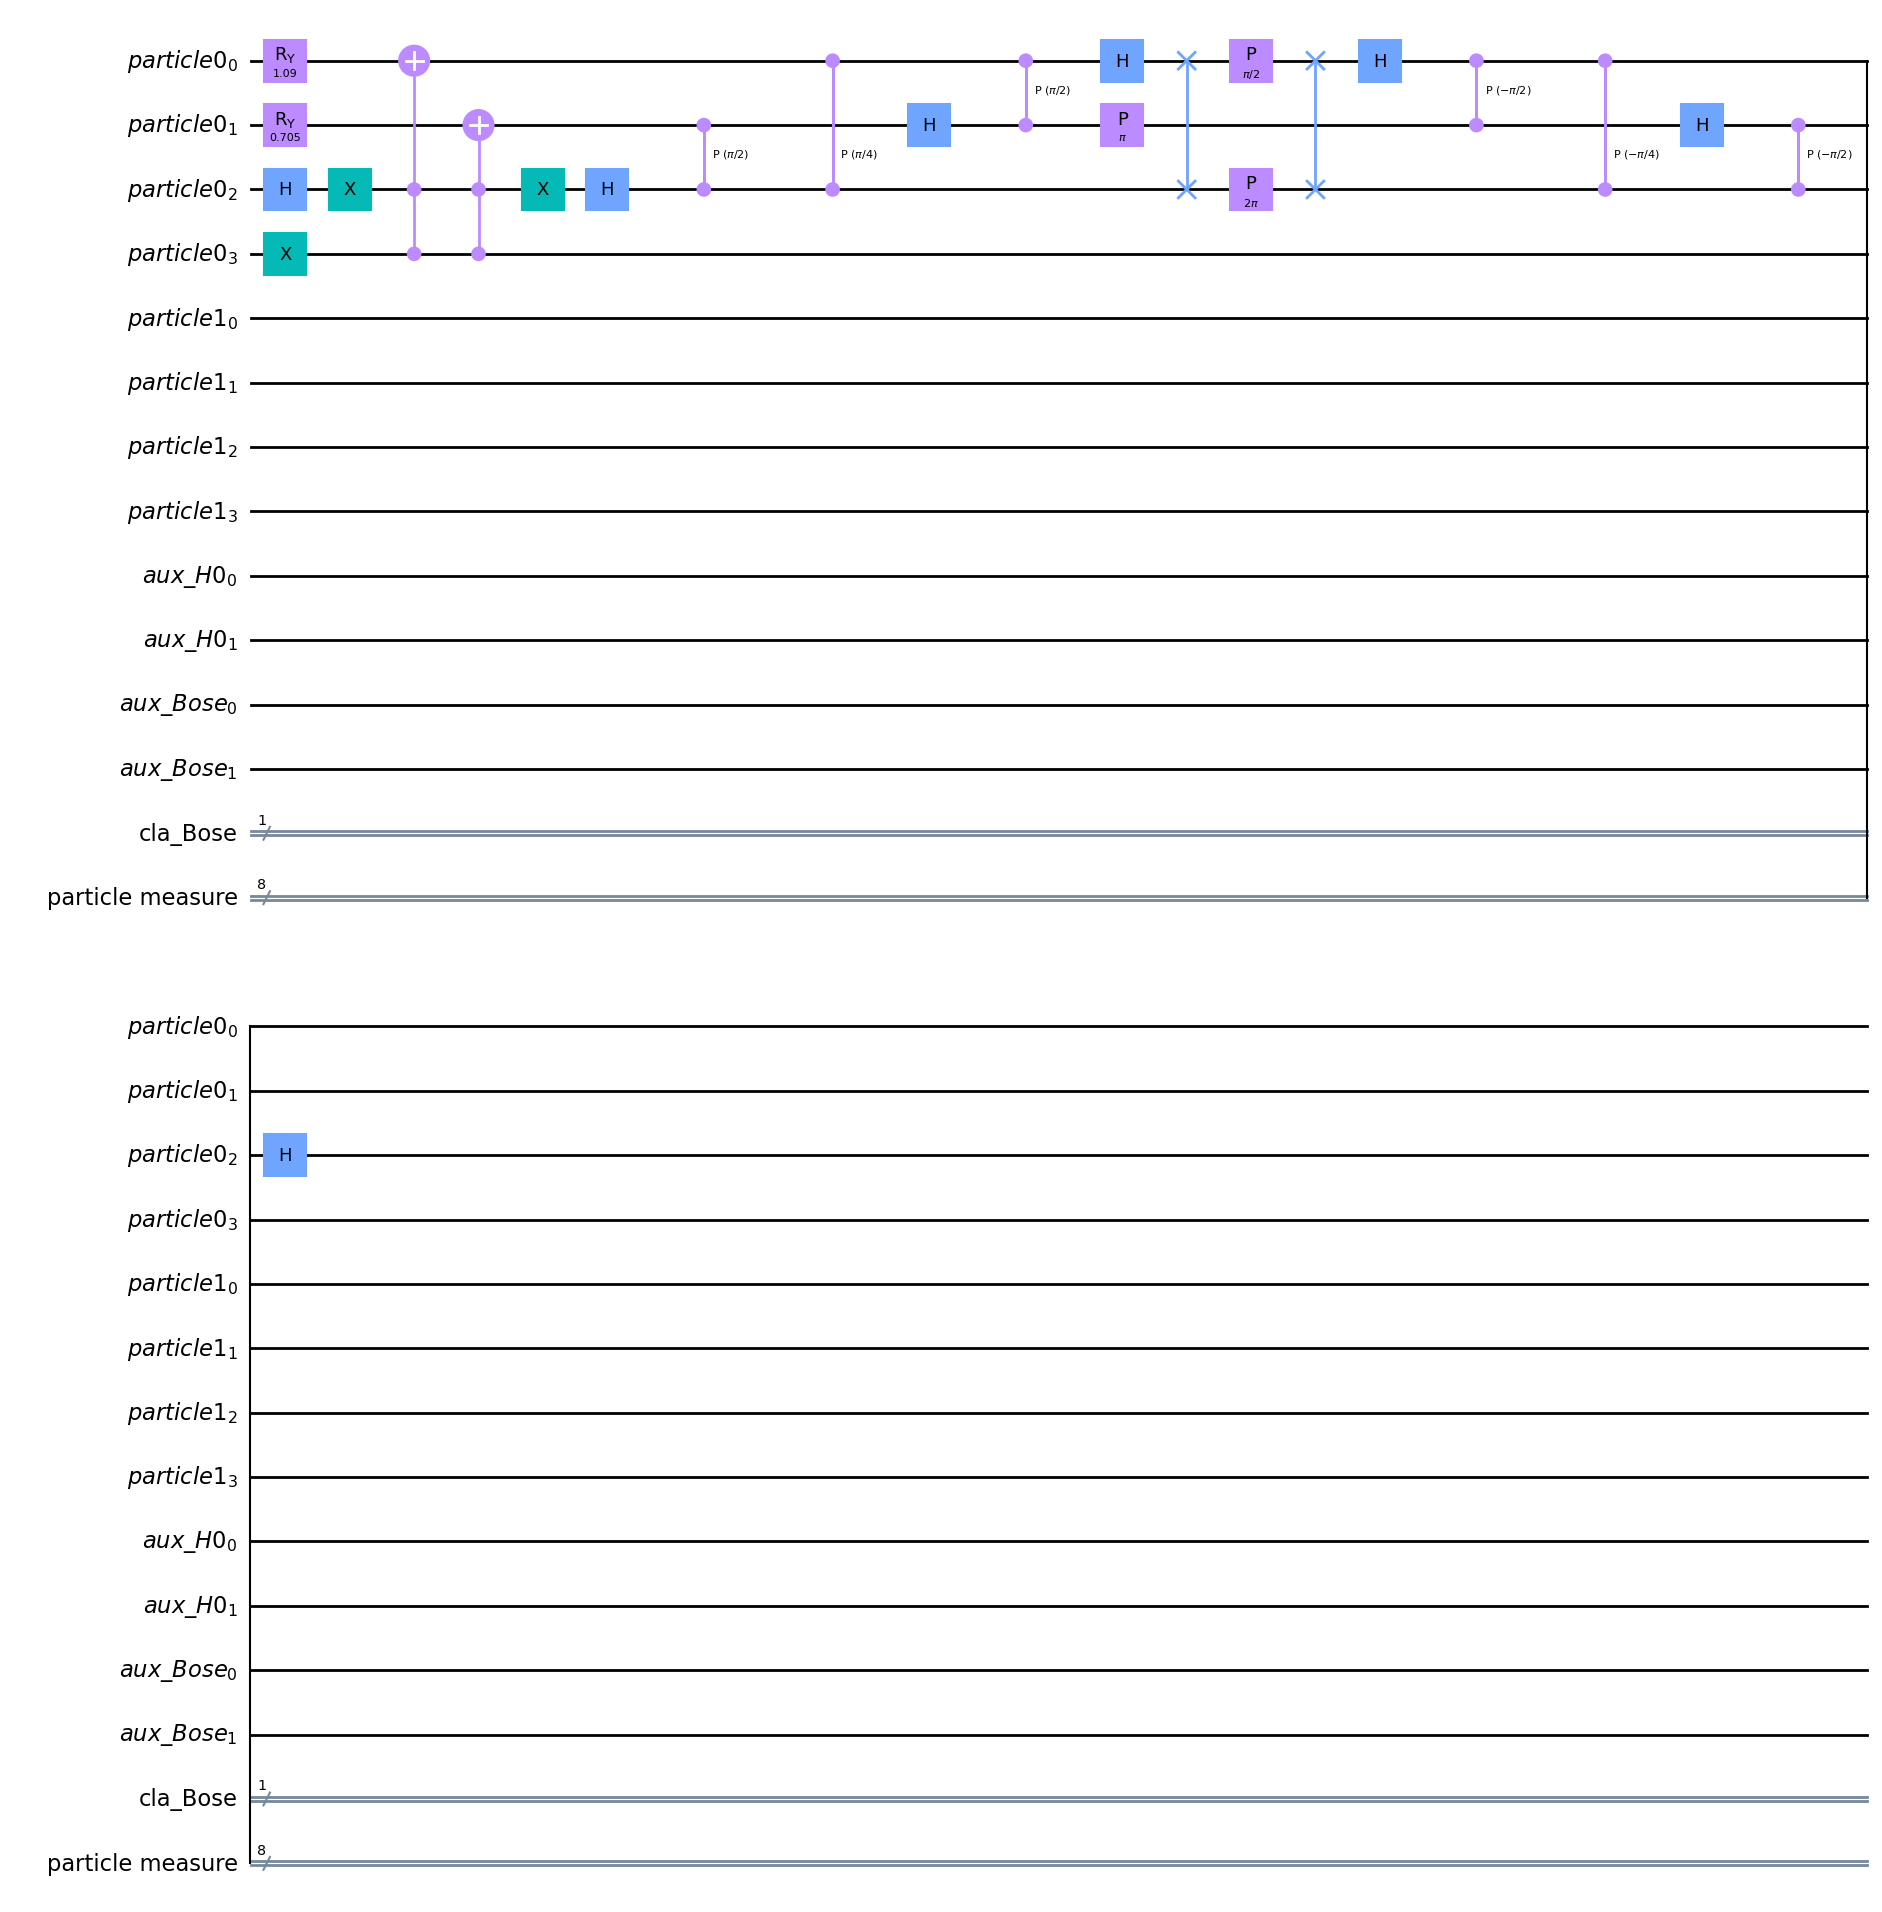

In [42]:
M = 2
N_abs = 2
N = N_abs * d + d + 1
d = 1
n = 1

circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
## Gaussian wave packet
for ireg in range(n):
    wave_packet_gate = wavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# ## translatoin parameters
# pos_trans_mat = np.zeros((n, d))
# pos_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# pos_trans_mat[1][0] = 4
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 2 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
# mom_trans_mat[1][0] = -1

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# ## translation in position space
# for ireg in range(n): # ireg番目の量子レジスタに作用
#     for idim in range(d): # idim次元目を考える
#         trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
#         trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
#         circuit.append(trans_gate, qargs=particle_regs[ireg][:])

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## translation in moemntum space
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

## inverse symmetric QFT and change representation
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    # basis_change_gate = changeBasis(particle_regs[ireg])
    # basis_change_gate.name = 'change basis'
    # circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])
## bose symmetrization (not done)

circuit.decompose().draw('mpl')

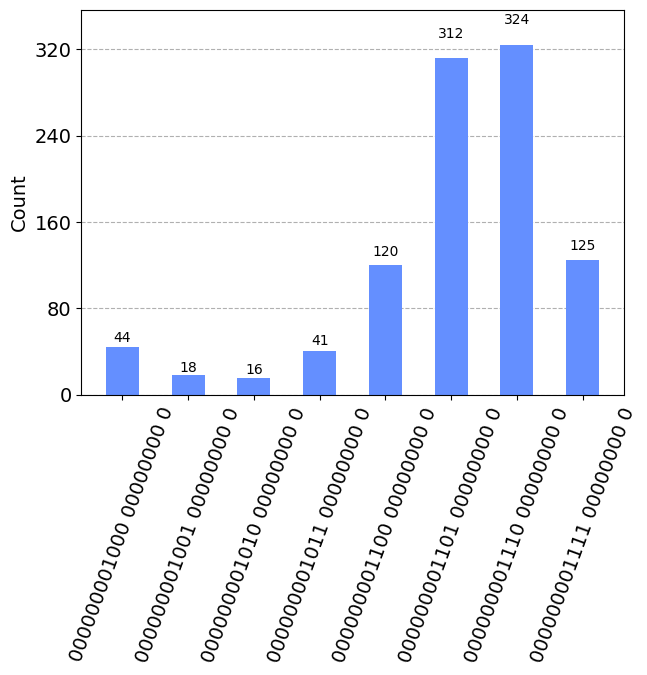

In [43]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)

#### B. Time Evolution ####

In [9]:
def phiAdditionGate(dphi, particle_regs, anc_reg_h0):
    phi_add_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    phi_add_circuit.h(anc_reg_h0) # equal superposition
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                phi_add_circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    phi_add_gate = phi_add_circuit.to_gate()
    return phi_add_gate

def uncomputePhiGate(dphi, particle_regs, anc_reg_h0):
    uncompute_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                uncompute_circuit.cp(- dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    uncompute_circuit.h(anc_reg_h0) # unsolve equal superposition
    uncompute_gate = uncompute_circuit.to_gate()
    return uncompute_gate

In [49]:
# |phi>|q1>|q2>...という状態なので, S_phiを構成するゲートを作る（普通のゲートと制御ゲートを作る）
def sPhiGate(anc_reg_h0, M, delta_0, a_s, m):
    N_s = 2 ** (N_abs + 1) # number of lattice per dimension
    ren_factor = ((2 * np.pi) / (N_s * a_s)) # factor to convert from q to p
    s_circuit = QuantumCircuit(anc_reg_h0)
    for ianc, qanc in enumerate(anc_reg_h0):
        phi = -delta_0 / M
        s_circuit.p(phi * ren_factor * (2 ** ianc), qanc) # approximate as massless particle
    s_gate = s_circuit.to_gate()
    cs_gate = s_gate.control(1)
    cs_gate.name = 'Cphi gate'
    return s_gate, cs_gate

In [12]:
# # you can check the motion of wave packets
# # time evolution scheme
# n = 1
# M = 1
# N_abs = 3
# N = N_abs + 2
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

# delta_t = np.pi/3
# pos_trans_mat = np.zeros((n, d))
# pos_trans_mat[0][0] = 8 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# mom_trans_mat = np.zeros((n, d))
# mom_trans_mat[0][0] = 0 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動

# ## localize wave packets
# for ireg in range(n):
#     # gauss_gate = preWavePacket(particle_regs[ireg])
#     wave_packet_gate = wavePacket(particle_regs[ireg])
#     wave_packet_gate.name = f'{ireg}th wave packet'
#     circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# # circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[0][2])

# ## translation in position space
# # change basis
# circuit.barrier()

# for ireg in range(n):
#     basis_change_gate = changeBasis(particle_regs[ireg])
#     basis_change_gate.name = 'change basis'
#     circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# for ireg in range(n): # ireg番目の量子レジスタに作用
#     for idim in range(d): # idim次元目を考える
#         trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
#         trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
#         circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# ## translation in momentum space
# circuit.barrier()

# # QFT
# for ireg in range(n):
#     qft_gate = qFT(particle_regs[ireg].size-1)
#     qft_gate.name = 'QFT'
#     circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

# ## translation
# for ireg in range(n): # ireg番目の量子レジスタに作用
#     for idim in range(d): # idim次元目を考える
#         trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
#         trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
#         circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# # inverse symmetric QFT
# for ireg in range(n):
#     inv_qft_gate = invQFT(particle_regs[ireg].size-1)
#     inv_qft_gate.name = 'inverse QFT'
#     circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])

# ## change basis
# for ireg in range(n):
#     basis_change_gate = changeBasis(particle_regs[ireg])
#     basis_change_gate.name = 'change basis'
#     circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# ## take summation of momenta of all particles
# dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
# phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
# phi_add_gate.name = 'phi addition'
# circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])

# # inverse QFT
# inv_qft_gate = invQFT(len(anc_reg_h0[:]))
# inv_qft_gate.name = 'invQFT'
# circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

# ## operate Sphi gate to evolve time
# s_gate, cs_gate = sPhiGate(anc_reg_h0, M, delta_t)
# s_gate.name = 'Sphi gate'
# circuit.append(s_gate, qargs=anc_reg_h0)

# ## uncompute phi ancilla qubits
# # QFT
# circuit.barrier()
# qft_gate = qFT(len(anc_reg_h0[:]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=anc_reg_h0[:])
# # uncompute
# uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
# uncompute_gate.name = 'uncompute phi'
# circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

# ## you can check the motion of the wave packet
# # change basis
# for ireg in range(n):
#     basis_change_gate = changeBasis(particle_regs[ireg])
#     basis_change_gate.name = 'change basis'
#     circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])
# # QFT
# qft_gate = qFT(len(particle_regs[0][:N-1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N-1])

# # circuit.draw('mpl')

In [ ]:
#### B. Time Evolution ####
## Free Hamiltonian ##

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[0][2])
# circuit.x(particle_regs[1][0])
# circuit.x(particle_regs[1][1])
# circuit.x(particle_regs[1][2])

# l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])
# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

# circuit.draw('mpl')

In [ ]:
# evolve time using ancilla qubits
circuit.barrier()
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, 0.5)
s_gate.name = 'Sphi gate'
cs_gate.name = 'Cphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)
for iregs in range(M):
    circuit.x(particle_regs[iregs][N - 1])
    cs_gate.name = 'Sphi gate'
    circuit.append(cs_gate, qargs=([particle_regs[iregs][N - 1]] + anc_reg_h0[:])) # n_omegaの数だけS_phiを作用
    circuit.x(particle_regs[iregs][N - 1])

# uncompute phi ancilla qubits
# QFT
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])

uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

# circuit.draw('mpl')

In [11]:
def momentum2omega(qmom, m, a_s):
    N_s = 2 ** (N_abs + 1) # number of lattice per dimension
    pmom = ((2 * np.pi) / (N_s * a_s)) * qmom
    # print('pmom', pmom)
    omega = np.sqrt(pmom ** 2 + m ** 2)
    return omega

# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def squeezeGate(qmom, ireg, jreg, m, a_s):
    omega = momentum2omega(qmom, m, a_s)
    # print('qmom', qmom)
    # print('omega', omega)
    zq = 0.5 * math.log(omega)
    reg_list = [ireg, jreg]
    qmode = int(qmom - 1/2)
    sq_circuit = QuantumCircuit(*reg_list)
    modebits = bin(qmode)[2:]

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])

    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])
    mcry = RYGate(- 2 * 2 * (zq/M)).control(2 * jreg.size - 1) # the first '2' means this involves q and -q, the second means offset of rotation gate
    sq_circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
    # sq_circuit.cry((zq/M), ireg[:]+jreg[:jreg.size-1], jreg[jreg.size-1])
    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])

    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])

    sq_gate = sq_circuit.to_gate()
    return sq_gate, modebits

# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def invSqueezeGate(qmom, ireg, jreg, m, a_s):
    omega = momentum2omega(qmom, m, a_s)
    # print('qmom', qmom)
    # print('omega', omega)
    zq = 0.5 * math.log(omega)
    reg_list = [ireg, jreg]
    qmode = int(qmom - 1/2)
    sq_circuit = QuantumCircuit(*reg_list)
    modebits = bin(qmode)[2:]

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])

    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])
    mcry = RYGate(2 * 2 * (zq/M)).control(2 * jreg.size - 1) # the first '2' means this involves q and -q, the second means offset of rotation gate
    sq_circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
    # sq_circuit.cry((zq/M), ireg[:]+jreg[:jreg.size-1], jreg[jreg.size-1])
    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])

    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])

    sq_gate = sq_circuit.to_gate()
    return sq_gate, modebits

In [24]:
## Scheme of squeezing operation
n = 1
M = 2
N_abs = 1
N = N_abs * d +d + 1
m = 0
a_s = 1
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

ireg = particle_regs[0]
jreg = particle_regs[1]
sq_gate, modebit = squeezeGate(1/2, jreg, ireg, m, a_s)
sq_gate.name = f'mode{0} sq'
circuit.append(sq_gate, qargs=jreg[:] + ireg[:])
circuit.barrier()
# circuit.ry(-2 * zq/M, particle_regs[1][-1])

# circuit.decompose().draw('mpl')

# ## Scheme of squeezing operation
# n = 2
# M = 2
# N_abs = 1
# N = N_abs * d +d + 1
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

# circuit.cx(particle_regs[1][-1], particle_regs[1][-2])
# circuit.cx(particle_regs[1][-1], particle_regs[0][-1])
# circuit.x(particle_regs[0][:])
# circuit.x(particle_regs[1][:-1])
# mcry = RYGate(-2 * zq/M).control(2 * jreg.size - 1)
# circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
# circuit.x(particle_regs[0][:])
# circuit.x(particle_regs[1][:-1])
# circuit.cx(particle_regs[1][-1], particle_regs[0][-1])
# circuit.cx(particle_regs[1][-1], particle_regs[1][-2])

circuit.barrier()
# circuit.decompose().draw('mpl')

In [12]:
def intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        # mcrx = PhaseGate(Delta * 6).control(2 * ireg.size - 2)
        mcrx = PhaseGate(-Delta).control(2 * ireg.size - 2)
        mcrx.name = 'Phase Gate'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:N-1])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [13]:
def intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list: 
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        mcrx = RXGate(2 * Delta).control(2 * ireg.size - 1)
        # mcrx = RXGate(2 * Delta * 8).control(2 * ireg.size - 1)
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [14]:
def intHamiltonianFourIndices(ireg, ipos, Delta): # done
    pos_bits = bin(ipos)[2:]

    int_circuit = QuantumCircuit(ireg)

    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                    
    int_circuit.x(ireg[:N_abs + d])
    mcrx = PhaseGate(-Delta).control(ireg.size - 2)
    mcrx.name = 'Phase Gate'
    int_circuit.append(mcrx, qargs=ireg[:N-1])
    # int_circuit.cp(Delta, ireg[:N_abs+d], ireg[N_abs+d])
    int_circuit.x(ireg[:N_abs + d])

    pos_bits = bin(ipos)[2:]
    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [15]:
def intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg] # ireg corresponds to sigma^2

    int_circuit = QuantumCircuit(ireg, jreg, kreg)

    for ihamming in three_hamming_list:
        # int_circuit.barrier()
        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
        # int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        # int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        # int_circuit.barrier()
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        # mcrx = RXGate(2 * Delta * 12).control(3 * ireg.size - 1)
        mcrx = RXGate(Delta).control(3 * ireg.size - 1) # 2倍いらない？なぜ？
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        # int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        # int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        # int_circuit.barrier()

        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

    int_gate = int_circuit.to_gate()

    return int_gate

In [16]:
def interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta):
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg, lreg]

    int_circuit = QuantumCircuit(ireg, jreg, kreg, lreg)

    for ihamming in hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])
        mcrx = RXGate(2 * Delta).control(4 * ireg.size - 1)
        # mcrx = RXGate(2 * Delta * 24).control(4 * ireg.size - 1) # 24 corresponds the permutation of registers 4! = 24
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:] + lreg[:jreg.size-1] + [lreg[lreg.size-1]])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [119]:
M = 3
N_abs = 1
d = 1
N = N_abs * d + d + 1
n = 1

circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
ipos = 0
ireg = particle_regs[0]
jreg = particle_regs[1]
kreg = particle_regs[2]
# lreg = particle_regs[3]
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101'] # 0 corresponds to vacuum state |Omega>^(i), 1 corresponds to |n>^(i)
# three_hamming_list = ['000']
delta = 1
coupling_lambda = 1
Delta = (delta * coupling_lambda) / (96 * (M ** 2))
# for ipos in range(2 ** (N_abs + d)-1, -1, -1):
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])


# int_gate = intHamiltonianFourIndices(ireg, ipos, Delta)
# circuit.append(int_gate, qargs=ireg[:])
# int_gate = intHamiltonianFourIndices(jreg, ipos, Delta)
# circuit.append(int_gate, qargs=jreg[:])
int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, 100 * Delta)
# int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta) # factor is 8
# int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta)
# int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta) # factor is 6
int_gate.name = f'pos{ipos} intH'
circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])
# circuit.append(int_gate, qargs=ireg[:]+jreg[:])
# circuit.append(int_gate, qargs=particle_1D_list)

# circuit.decompose().draw('mpl')

In [19]:
M = 3
N_abs = 1
d = 1
N = N_abs * d + d + 1
n = 1
a_s = 1

tau_0 = 0.5 # Wigner delay
tau_I = 0 # length of time of interaction
delta = 1 # time step
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
m_0 = 0 # chosen to represent a relevant enrgy scale in the weak coupling regime
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101']
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
lambda_t = 1
Delta = (delta * 100 * lambda_t) / (96 * (M ** 2))

for ipos in range(2 ** (N_abs * d + d)): # non-commutative
    # print('ipos', ipos)
    dummy = 0
if dummy == 0:
    ipos = 0

    # 3 indices match
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            if inum < jnum:
                print('3 indices;', 'inum', inum, 'jnum', jnum)
                int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, 8 * Delta)
                # int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta)
                int_gate.name = f'pos{ipos} intH3'
                circuit.append(int_gate, qargs=ireg[:]+jreg[:])

    # 2 indices match
    print('ipos', ipos)
    for inum, ireg in enumerate(particle_regs):
        for jnum, jreg in enumerate(particle_regs):
            for knum, kreg in enumerate(particle_regs):
                if inum != jnum and inum != knum and jnum < knum:
                    print('2 indices;', 'inum', inum, 'junm', jnum, 'knum', knum)
                    int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, 12 * Delta)
                    # int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
                    int_gate.name = f'pos{ipos} intH2'
                    circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])

# circuit.draw('mpl')
# Show the state vector
                    
simulator = AerSimulator(method='statevector')
circuit.save_statevector()
circuit = transpile(circuit, backend=simulator)
statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# print(statevector)

list = []
eps = 0.001
for i in range(len(statevector)):
    if np.abs(statevector[i]) > eps:
        list.append(statevector[i])
        print(i)
list

3 indices; inum 0 jnum 1
3 indices; inum 0 jnum 2
3 indices; inum 1 jnum 2
ipos 0
2 indices; inum 0 junm 1 knum 2
2 indices; inum 1 junm 0 knum 2
2 indices; inum 2 junm 0 knum 1
0
36
260
288


[(-0.3106325880191597+0.39828697065147056j),
 (0.3666173984023967-0.3374660149979726j),
 (0.36661739840239826-0.33746601499797135j),
 (0.3666173984023977-0.33746601499797113j)]

In [10]:
# # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# # print(statevector)

# list = []
# eps = 0.001
# for i in range(len(statevector)):
#     if np.abs(statevector[i]) > eps:
#         list.append(statevector[i])
#         print(i)
# list

In [401]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
# # for ipos in range(2 ** ((N_abs * d + d))):
# # 2 indices match
# for inum, ireg in enumerate(particle_regs):
#     for jnum, jreg in enumerate(particle_regs):
#         for knum, kreg in enumerate(particle_regs):
#             if inum != jnum and inum != knum and jnum < knum:
#                 print('inum, junm, knum', inum, jnum, knum)
#                 # int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, 12 * Delta)
#                 int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
#                 # int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
#                 int_gate.name = f'pos{ipos} intH2'
#                 circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])

### B. Time evolution all part ###

In [33]:
M = 2
N_abs = 1
d = 1
N = N_abs * d + d + 1
n = 1
a_s = 1

tau_0 = 0.5 # Wigner delay
tau_I = 0 # length of time of interaction
delta = 1 # time step
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
m_0 = 0 # chosen to represent a relevant enrgy scale in the weak coupling regime
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101']
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
# three_hamming_list = ['000']

tau = 0
m_t = m_0
lambda_t = 1

m_ren = m_0
lambda_ren = 1
count = 0

while tau <= tau_0 + tau_I:
    Delta = (delta * lambda_t) / (96 * (M ** 2))
    # ## take summation of momenta of all particles
    # dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
    # phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
    # phi_add_gate.name = 'phi addition'
    # circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])

    # # inverse QFT
    # inv_qft_gate = invQFT(len(anc_reg_h0[:]))
    # inv_qft_gate.name = 'invQFT'
    # circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

    # ## operate Sphi gate to evolve time
    # s_gate, cs_gate = sPhiGate(anc_reg_h0, M, delta)
    # s_gate.name = 'Sphi gate'
    # circuit.append(s_gate, qargs=anc_reg_h0)

    # ## uncompute phi ancilla qubits
    # # QFT
    # # circuit.barrier()
    # qft_gate = qFT(len(anc_reg_h0[:]))
    # qft_gate.name = 'QFT'
    # circuit.append(qft_gate, qargs=anc_reg_h0[:])
    # # uncompute
    # uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
    # uncompute_gate.name = 'uncompute phi'
    # circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])
    # circuit.barrier()

    # inverse Squeezing operation
    for imode in range(2 ** N_abs-1, -1, -1):
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum != jnum:
                    # print('inum, jnum', inum, jnum)
                    # print('ireg, jreg', ireg, jreg)
                    qmom = (imode + 1/2)
                    inv_sq_gate, modebit = invSqueezeGate(qmom, ireg, jreg, m_t, a_s)
                    inv_sq_gate.name = f'mode{imode+(1/2)} inv sq'
                    circuit.append(inv_sq_gate, qargs=ireg[:]+jreg[:])

    # symmetric inverse QFT
    for ireg in range(M):
        change_gate = changeBasis(particle_regs[ireg])
        change_gate.name = 'change basis'
        circuit.append(change_gate, qargs=particle_regs[ireg][:])
        inv_qft_gate =invQFT(particle_regs[ireg].size-1)
        inv_qft_gate.name = 'invQFT'
        circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:-1])

    # interaction part
    for ipos in range(2 ** (N_abs * d + d)): # non-commutative
        print('ipos', ipos)
    #     dummy = 0
    # if dummy == 0:
        # ipos = 1
        # 4 indices match
        for inum, ireg in enumerate(particle_regs):
            # print('4 indices; inum', inum)
            int_gate = intHamiltonianFourIndices(ireg, ipos, Delta)
            int_gate.name = f'pos{ipos} intH4'
            circuit.append(int_gate, qargs=ireg[:])

        # 3 indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum < jnum:
                    # print('3 indices;', 'inum', inum, 'jnum', jnum)
                    int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, 8 * Delta)
                    # int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta)
                    int_gate.name = f'pos{ipos} intH3'
                    circuit.append(int_gate, qargs=ireg[:]+jreg[:])

        # 2 pairs of indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum < jnum:
                    # print('2 pairs; inum', inum, 'junm', jnum)
                    int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, 6 * Delta)
                    # int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta)
                    int_gate.name = f'pos{ipos} intH22'
                    circuit.append(int_gate, qargs=ireg[:]+jreg[:])

        # 2 indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                for knum, kreg in enumerate(particle_regs):
                    if inum != jnum and inum != knum and jnum < knum:
                        # print('2 indices;', 'inum', inum, 'junm', jnum, 'knum', knum)
                        int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, 12 * Delta)
                        # int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
                        int_gate.name = f'pos{ipos} intH2'
                        circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])

        # all differ
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                for knum, kreg in enumerate(particle_regs):
                    for lnum, lreg in enumerate(particle_regs):
                        if inum < jnum and jnum < knum and knum < lnum:
                            # print('all differ; inum, junm, knum, lnum', inum, jnum, knum, lnum)
                            int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, 24 * Delta)
                            # int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta)
                            int_gate.name = f'pos{ipos} intH'
                            circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:]+lreg[:])

    circuit.barrier()

    # symmetric QFT
    for ireg in range(M):
        qft_gate =qFT(particle_regs[ireg].size-1)
        qft_gate.name = 'QFT'
        circuit.append(qft_gate, qargs=particle_regs[ireg][:-1])
        change_gate = changeBasis(particle_regs[ireg])
        change_gate.name = 'change basis'
        circuit.append(change_gate, qargs=particle_regs[ireg][:])

    circuit.barrier()

    # Squeezing operation
    for imode in range(2 ** N_abs):
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum != jnum:
                    # print('inum, jnum', inum, jnum)
                    qmom = (imode + 1/2)
                    sq_gate, modebit = squeezeGate(qmom, jreg, ireg, m_t, a_s)
                    sq_gate.name = f'mode{imode+(1/2)} sq'
                    circuit.append(sq_gate, qargs=jreg[:]+ireg[:])

    circuit.barrier()

    tau += delta
    if tau < tau_0: # turn on interaction adiabatically
        lambda_t = lambda_ren * (tau / tau_0)
        m_t = m_0 * (1 - (tau / tau_0)) + m_ren * (tau / tau_0)
    elif tau_0 <= tau : # interaction completely
        m_t = m_ren
        lambda_t = lambda_ren
    circuit.barrier()
    count += 1
    print('We count', count, 'steps')

# circuit.draw('mpl')

ipos 0
ipos 1
ipos 2
ipos 3
We count 1 steps


In [34]:
# Show the state vector
simulator = AerSimulator(method='statevector')
circuit.save_statevector()
circuit = transpile(circuit, backend=simulator)
statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
# print(statevector)

list = []
eps = 0.01
for i in range(len(statevector)):
    if np.abs(statevector[i]) > eps:
        list.append(statevector[i])
        print(i)
list

0


[(0.9997809434351266-0.00921355848442368j)]

In [35]:
# Calculate Fidelity
# # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])

# 計算結果を含んだファイルをインポート
# %run 'matrix_cal.ipynb'
result_file = 'calculated_result.pkl'

# 計算結果を読み込む
with open(result_file, 'rb') as f:
    loaded_result_state = pickle.load(f)

# 計算結果を使って何かを行う
ket_state = loaded_result_state
# print(result_state)
# print(result_state)

# print(np.linalg.norm(statevector - result_state))
bra_state = np.conjugate(statevector.T)
print(np.abs(np.dot(bra_state, ket_state)) ** 2)

0.9999997413453051


In [ ]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    # particle registers
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))

    # ancilla registers
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
    ancilla_register_symm = AncillaRegister(s + 1, name = f'aux_Bose') # aux registers for Bose symmetrization

    # classical registers
    classical_register_symm = ClassicalRegister(1, name = 'cla_Bose')
    classical_register_measurement = ClassicalRegister(N * M, name = 'particle measure')

    # merge into circuit
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement)
    particle_1D_list = [element for sublist in particle_registers for element in sublist]
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement, particle_1D_list

# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
# circuit.draw('mpl')

/Users/maeno0ta/single-particle-qft/.venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


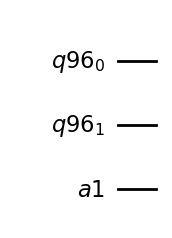

In [74]:
reg = QuantumRegister(2)
anc = AncillaRegister(1)
circuit = QuantumCircuit(reg, anc)
circuit.draw('mpl')

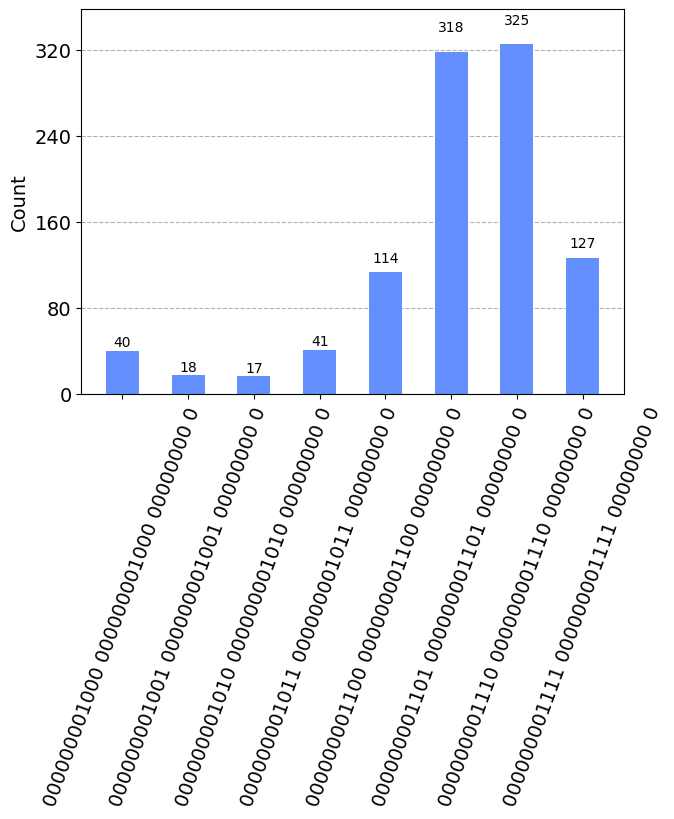

In [47]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)

## 実機を使う

In [11]:
# pip install qiskit-ibm-runtime
from qiskit_ibm_runtime import QiskitRuntimeService

In [12]:
# アカウント情報の保存（API tokenをコピーして貼り付ける）
QiskitRuntimeService.save_account(token='1d1c9daedc419a4eca98250b7e6fcf30d2552c02d5e87e42054a453c316f7eb2cbd20d209d4dd360a32d40bff90b951db341491e46ba4e4f3c5b8afedfe1e178',
                                  channel='ibm_quantum', overwrite=True)

In [13]:
service = QiskitRuntimeService(channel='ibm_quantum')

## バックエンドのリストをダウンロード
# service.backends()

##使えるインスタンスのリストをダウンロード
# service.instances()

In [14]:
# 特定のバックエンドを使用
# インスタンスを指定しないとプライオリティの低いバックエンドが得られるかもしれない
backend = service.get_backend('ibm_kawasaki', instance='utokyo-kawasaki/internal/icepp-r5')

# # 最も空いているバックエンドを使用
# # インスタンスを指定しないとopenのものが返ってくるかもしれない
# backend = service.least_busy(
#     simulator=False,
#     filters=lambda b: b.name != 'ibm_oslo',
#     instance='ibm-q-utokyo/internal/icepp-r5'
# )

「論理」回路をバックエンドが理解できる「物理」回路に変換する（transpile）。`transpile()`関数には回路を個別に渡してもいいし、リストごと渡してもいい

In [44]:
tcircuits = transpile(circuit, backend=backend, optimization_level=2)
tcircuits.draw(idle_wires=False)

global phase: π/2
                                                                            »
  aux_Bose_0 -> 34 ─────────────────────────────────────────────────────────»
                                                                            »
    aux_H0_1 -> 52 ─────────────────────────────────────────────────────────»
                                                                            »
 particle1_1 -> 61 ─────────────────────────────────────────────────────────»
                                                                            »
 particle1_2 -> 67 ─────────────────────────────────────────────────────────»
                                                                            »
 particle1_3 -> 70 ─────────────────────────────────────────────────────────»
                    ┌────────┐      ┌────┐    ┌─────────┐           ┌──────┐»
 particle0_3 -> 72 ─┤ Rz(-π) ├──────┤ √X ├────┤ Rz(π/2) ├───────────┤1     ├»
                    └─┬────┬─┘ ┌────┴────┴───┐└─────────┘           │      │»
 particle0_1 -> 80 ───┤ √X ├───┤ Rz(0.70503) ├──────────────────────┤  Ecr ├»
                      ├────┤   └┬────────────┤   ┌────┐  ┌─────────┐│      │»
 particle0_0 -> 81 ───┤ √X ├────┤ Rz(1.0904) ├───┤ √X ├──┤ Rz(π/2) ├┤0     ├»
                   ┌──┴────┴──┐ └───┬────┬───┘   └────┘  └─────────┘└──────┘»
 particle0_2 -> 82 ┤ Rz(-π/2) ├─────┤ √X ├──────────────────────────────────»
                   └──────────┘     └────┘                                  »
 aux_Bose_1 -> 111 ─────────────────────────────────────────────────────────»
                                                                            »
   aux_H0_0 -> 117 ─────────────────────────────────────────────────────────»
                                                                            »
particle1_0 -> 119 ─────────────────────────────────────────────────────────»
                                                                            »
          meas: 12/═════════════════════════════════════════════════════════»
                                                                            »
«                                                                           »
«  aux_Bose_0 -> 34 ────────────────────────────────────────────────────────»
«                                                                           »
«    aux_H0_1 -> 52 ────────────────────────────────────────────────────────»
«                                                                           »
« particle1_1 -> 61 ────────────────────────────────────────────────────────»
«                                                                           »
« particle1_2 -> 67 ────────────────────────────────────────────────────────»
«                                                                           »
« particle1_3 -> 70 ────────────────────────────────────────────────────────»
«                      ┌────┐                                               »
« particle0_3 -> 72 ───┤ √X ├───────────────────────────────────────────────»
«                      └────┘                                               »
« particle0_1 -> 80 ────────────────────────────────────────────────────────»
«                   ┌──────────┐┌────┐┌──────────┐┌────┐┌──────┐┌──────────┐»
« particle0_0 -> 81 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(3π/4) ├┤ √X ├┤1     ├┤ Rz(-π/4) ├»
«                   └──────────┘└────┘└──────────┘└────┘│  Ecr │└──┬───┬───┘»
« particle0_2 -> 82 ────────────────────────────────────┤0     ├───┤ X ├────»
«                                                       └──────┘   └───┘    »
« aux_Bose_1 -> 111 ────────────────────────────────────────────────────────»
«                                                                           »
«   aux_H0_0 -> 117 ────────────────────────────────────────────────────────»
«                                                                           »
«particle1_0 -> 119 ────────────────────────────────────────────────────────»
«   

In [20]:
# バックエンドで実行する
job = backend.run(tcircuits, shots=1000)

In [ ]:
# 本当にjobを走らせるのはこっち
result = job.result()
counts = result.get_counts()
plot_histogram(counts[-1])

## Sessionを使った実行

In [16]:
from qiskit_ibm_runtime import Session

session = Session(backend=backend)

In [45]:
# トランスパイル回路を受け取って回す
options = {'job_tags': ['anything', 'you', 'like']}
inputs = {'circuits': tcircuits, 'skip_transpilation': True, 'shots': 1000}
job = session.run('circuit-runner', inputs, options=options)

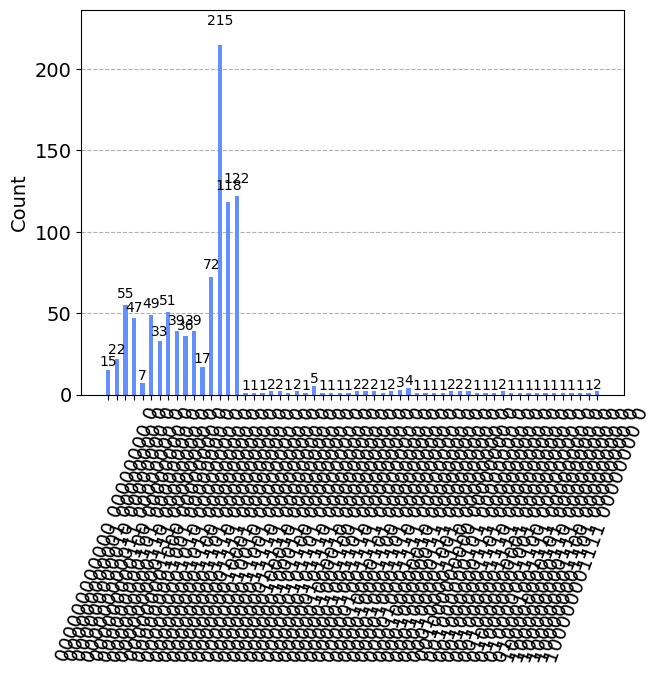

In [46]:
# jobの実行
result = job.result()
counts = result.get_counts()
plot_histogram(counts)